In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Add
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
import pickle

# Load dataset
data = pd.read_csv("diabetes_dataset.csv")
data.dropna(subset=["diabetes"], inplace=True)

# Preprocess data
X = data.drop("diabetes", axis=1)
Y = data["diabetes"].astype(int)

# Encode categorical features
label_encoder = LabelEncoder()
X["gender"] = label_encoder.fit_transform(X["gender"])
X["smoking_history"] = label_encoder.fit_transform(X["smoking_history"])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)

# Define custom layer
class SkipDense(tf.keras.layers.Layer):
    def __init__(self, units, activation="relu", **kwargs):
        super(SkipDense, self).__init__(**kwargs)
        self.dense1 = Dense(units, activation=activation)
        self.dense2 = Dense(units, activation=activation)

    def call(self, inputs):
        hidden1 = self.dense1(inputs)
        hidden2 = self.dense2(hidden1)
        return Add()([hidden1, hidden2])

    def get_config(self):
        config = super(SkipDense, self).get_config()
        config.update({"units": self.dense1.units})
        return config

# Build model
model = Sequential([
    Input(shape=(X_pca.shape[1],)),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(2, activation="softmax")
])

# Compile and train
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# Save model properly
model.save("diabetes_detector.h5")

# Save weights using pickle
with open("diabetes_detector.pkl", 'wb') as f:
    pickle.dump(model.get_weights(), f)

# Set up LIME explainer
explainer = LimeTabularExplainer(
    X_train, training_labels=Y_train, mode="classification",
    feature_names=[f"PC{i+1}" for i in range(X_train.shape[1])],
    discretize_continuous=False
)

# Save scaler and PCA as pickle
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("pca.pkl", "wb") as f:
    pickle.dump(pca, f)


Epoch 1/100
800/800 [==============================] - 7s 5ms/step - loss: 0.3042 - accuracy: 0.8674 - val_loss: 0.2574 - val_accuracy: 0.8850
Epoch 2/100
800/800 [==============================] - 4s 5ms/step - loss: 0.2684 - accuracy: 0.8780 - val_loss: 0.2559 - val_accuracy: 0.8894
Epoch 3/100
800/800 [==============================] - 4s 5ms/step - loss: 0.2620 - accuracy: 0.8795 - val_loss: 0.2504 - val_accuracy: 0.8872
Epoch 4/100
800/800 [==============================] - 4s 5ms/step - loss: 0.2613 - accuracy: 0.8805 - val_loss: 0.2516 - val_accuracy: 0.8863
Epoch 5/100
800/800 [==============================] - 4s 5ms/step - loss: 0.2611 - accuracy: 0.8801 - val_loss: 0.2501 - val_accuracy: 0.8825
Epoch 6/100
800/800 [==============================] - 4s 5ms/step - loss: 0.2573 - accuracy: 0.8810 - val_loss: 0.2499 - val_accuracy: 0.8853
Epoch 7/100
800/800 [==============================] - 4s 5ms/step - loss: 0.2555 - accuracy: 0.8835 - val_loss: 0.2511 - val_accuracy: 0.8869

c:\Users\medis\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("pca.pkl", "wb") as f:
    pickle.dump(pca, f)


In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Add
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
import gradio as gr



In [16]:
# Load and preprocess dataset
data = pd.read_csv("diabetes_dataset.csv")
data.dropna(subset=["diabetes"], inplace=True)



In [17]:
data.shape

(20000, 9)

In [18]:
# Separate features and target
X = data.drop("diabetes", axis=1)
Y = data["diabetes"].astype(int)



In [19]:
# Encode categorical features
label_encoder = LabelEncoder()
X["gender"] = label_encoder.fit_transform(X["gender"])
X["smoking_history"] = label_encoder.fit_transform(X["smoking_history"])



In [20]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [21]:

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)



In [22]:
# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)



In [23]:
# Build neural network with skip connections
class SkipDense(tf.keras.layers.Layer):
    def __init__(self, units, activation="relu"):
        super().__init__()
        self.dense1 = Dense(units, activation=activation)
        self.dense2 = Dense(units, activation=activation)

    def call(self, inputs):
        hidden1 = self.dense1(inputs)
        hidden2 = self.dense2(hidden1)
        return Add()([hidden1, hidden2])



In [24]:
class SkipDense(tf.keras.layers.Layer):
    def __init__(self, units, activation="relu", **kwargs):
        super(SkipDense, self).__init__(**kwargs)
        self.dense1 = Dense(units, activation=activation)
        self.dense2 = Dense(units, activation=activation)

    def call(self, inputs):
        hidden1 = self.dense1(inputs)
        hidden2 = self.dense2(hidden1)
        return Add()([hidden1, hidden2])

    def get_config(self):
        config = super(SkipDense, self).get_config()
        config.update({"units": self.dense1.units})
        return config


In [25]:
# Build a deeper neural network with skip connections
model = Sequential([
    Input(shape=(X_pca.shape[1],)),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(64),
    Dropout(0.3),
    SkipDense(128),
    Dropout(0.4),
    SkipDense(128),
    Dropout(0.4),
    SkipDense(128),
    Dropout(0.4),
    SkipDense(256),
    Dropout(0.5),
    SkipDense(256),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dropout(0.2),
    Dense(8, activation="relu"),
    Dropout(0.2),
    Dense(2, activation="softmax")  # Output layer
])





In [26]:
# Compile and train the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

history = model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
accuracy = model.evaluate(X_test, Y_test, verbose=0)[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Test Accuracy: 88.10%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
Y_pred_probs = model.predict(X_test)
Y_pred = np.argmax(Y_pred_probs, axis=1)



125/125 [==============================] - 1s 3ms/step


In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred, target_names=["Non-Diabetic", "Diabetic"]))



Classification Report:
              precision    recall  f1-score   support

Non-Diabetic       0.87      0.92      0.90      2251
    Diabetic       0.90      0.82      0.86      1749

    accuracy                           0.88      4000
   macro avg       0.88      0.87      0.88      4000
weighted avg       0.88      0.88      0.88      4000



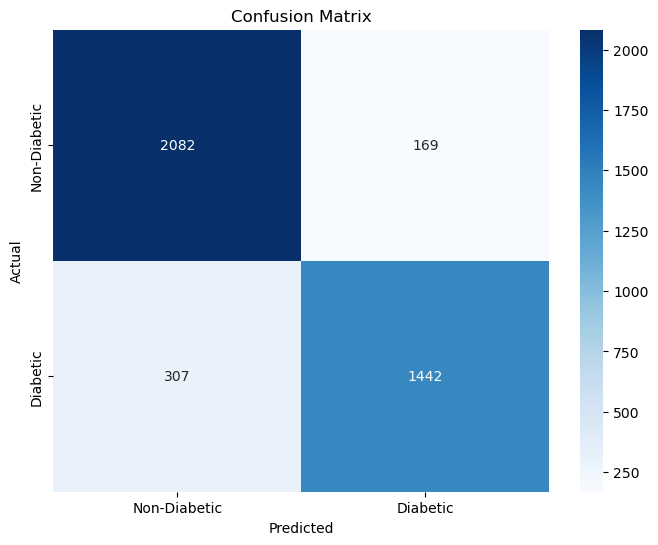

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Diabetic", "Diabetic"], yticklabels=["Non-Diabetic", "Diabetic"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
# Save the model
model.save("diabetes_detector")



INFO:tensorflow:Assets written to: diabetes_detector\assets


INFO:tensorflow:Assets written to: diabetes_detector\assets


In [ ]:
# Load the saved model
model = load_model("diabetes_detector")




In [ ]:
# LIME explainer setup
explainer = LimeTabularExplainer(
    X_train, training_labels=Y_train, mode="classification", feature_names=[f"PC{i+1}" for i in range(X_train.shape[1])]
)



In [ ]:
# Prediction function
def predict_diabetes(gender, age, hypertension, heart_disease, smoking_history, bmi, hba1c_level, blood_glucose_level):
    try:
        # Map gender and smoking history
        gender_map = {"Male": 1, "Female": 0}
        smoking_map = {"Never": 0, "Current": 1, "Former": 2, "Not Current": 3, "No Info": 4, "Ever": 5}

        # Validate inputs
        gender_num = gender_map[gender]
        smoking_num = smoking_map[smoking_history]

        # Prepare input data
        input_data = np.array([[gender_num, age, hypertension, heart_disease, smoking_num, bmi, hba1c_level, blood_glucose_level]])

        # Standardize and apply PCA
        input_scaled = scaler.transform(input_data)
        input_pca = pca.transform(input_scaled)

        # Predict
        prediction = model.predict(input_pca)
        is_diabetic = np.argmax(prediction, axis=1)[0]
        probability = prediction[0][is_diabetic]

        # Generate unique precautions based on probability
        if is_diabetic:
            if probability > 0.9:
                precautions = (
                    "You are at an extremely high risk of diabetes. Immediate medical intervention is critical. "
                    "Start diabetes management under medical supervision, avoid high-sugar foods completely, "
                    "and maintain a structured physical activity routine tailored by a healthcare provider."
                )
            elif probability > 0.8:
                precautions = (
                    "You are at a very high risk of diabetes. Consult a healthcare provider immediately to explore "
                    "medication options. Adopt a strict low-glycemic diet and monitor your blood sugar levels daily."
                )
            elif probability > 0.7:
                precautions = (
                    "Your diabetes risk is high. Begin regular blood sugar monitoring and increase physical activity. "
                    "Focus on reducing refined carbs, and include lean protein sources like fish and legumes in your diet."
                )
            elif probability > 0.6:
                precautions = (
                    "You are moderately at risk of diabetes. Incorporate 30-45 minutes of aerobic exercise daily. "
                    "Reduce your intake of processed foods and sugary beverages. Consult a dietitian for meal planning."
                )
            elif probability > 0.5:
                precautions = (
                    "Your diabetes risk is moderate. Schedule a glucose tolerance test to assess your condition. "
                    "Increase your intake of whole grains and leafy greens, and avoid sedentary behavior."
                )
            elif probability > 0.4:
                precautions = (
                    "You are at a slightly elevated risk of diabetes. Focus on weight management through regular exercise "
                    "and portion control. Stay hydrated and ensure you get at least 7-8 hours of sleep per night."
                )
            elif probability > 0.3:
                precautions = (
                    "Your risk of diabetes is low to moderate. Minimize your consumption of sugary snacks, "
                    "and include stress-relieving activities like yoga or meditation to promote overall health."
                )
            elif probability > 0.2:
                precautions = (
                    "Your diabetes risk is relatively low. Continue with a balanced diet that includes a variety of vegetables, "
                    "and aim for 150 minutes of moderate exercise weekly. Have your blood glucose levels checked annually."
                )
            elif probability > 0.1:
                precautions = (
                    "You are at a minimal risk of diabetes. Maintain your current healthy habits. Avoid prolonged periods of inactivity, "
                    "and include omega-3-rich foods like nuts and seeds in your diet."
                )
            else:
                precautions = (
                    "You have an extremely low risk of diabetes. Keep up your healthy lifestyle. Stay active, eat a diverse diet, "
                    "and avoid unnecessary weight gain to maintain your current health."
                )
        else:
            precautions = (
                "You are not prone to diabetes. Maintain a healthy lifestyle, including regular physical activity, "
                "a balanced diet, and routine health check-ups to prevent any future risks."
            )

        # Perform LIME analysis
        explanation = explainer.explain_instance(input_pca[0], model.predict)
        lime_filename = "lime_analysis.html"
        explanation.save_to_file(lime_filename)

        return {
            "Prediction": "Diabetic" if is_diabetic else "Non-Diabetic",
            "Probability": f"{probability * 100:.2f}%",
            "Precautions": precautions,
            "LIME Analysis": f"LIME analysis saved to {lime_filename}. Open it in a browser to view."
        }

    except Exception as e:
        return {
            "Prediction": f"Error: {str(e)}",
            "Probability": "Error",
            "Precautions": "Error",
            "LIME Analysis": "Error"
        }



In [ ]:
# Gradio interface
def gradio_interface(gender, age, hypertension, heart_disease, smoking_history, bmi, hba1c_level, blood_glucose_level):
    result = predict_diabetes(gender, age, hypertension, heart_disease, smoking_history, bmi, hba1c_level, blood_glucose_level)
    return result["Prediction"], result["Probability"], result["Precautions"], result["LIME Analysis"]

interface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Radio(["Male", "Female"], label="Gender"),
        gr.Slider(0, 120, step=1, label="Age"),
        gr.Radio([0, 1], label="Hypertension (0: No, 1: Yes)"),
        gr.Radio([0, 1], label="Heart Disease (0: No, 1: Yes)"),
        gr.Dropdown(["Never", "Current", "Former", "Not Current", "No Info", "Ever"], label="Smoking History"),
        gr.Slider(10, 50, step=0.1, label="BMI"),
        gr.Slider(4.0, 15.0, step=0.1, label="HbA1c Level"),
        gr.Slider(50, 300, step=1, label="Blood Glucose Level")
    ],
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Textbox(label="Probability"),
        gr.Textbox(label="Precautions"),
        gr.Textbox(label="LIME Analysis")
    ],
    title="Diabetes Prediction",
    description="Enter the details below to predict if a person is diabetic and view precautions.",
    theme="default",
    live=False
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7862

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/11/28 16:14:05 [W] [service.go:132] login to server failed: dial tcp: lookup gradio-live.com: i/o timeout
